In [1]:
import numpy as np
import pandas as pd
import json
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from mllib.params import FieldNames, FileNames
from mllib.utils import load_pickle

In [2]:
def make_x_y(x_tr, x_val, flag='val'):
    y_tr = x_tr['redemption_status'].values
    del x_tr['redemption_status']

    if flag == 'val':
        y_val = x_val['redemption_status'].values
        del x_val['redemption_status']
    else:
        y_val = None
    return x_tr, y_tr, x_val, y_val


def get_rank_features(df):
    df['cust_coupon_rank1'] = df.groupby(['customer_id', 'campaign_id'])['common_item_set_0'].rank('max')/df['customer_campaign_count']
    df['cust_coupon_rank2'] = df.groupby(['customer_id', 'campaign_id'])['common_item_set_1'].rank('max')/df['customer_campaign_count']
    df['cust_coupon_rank3'] = df.groupby(['customer_id', 'campaign_id'])['common_item_set_2'].rank('max')/df['customer_campaign_count']
    df['customer_rank1'] = df.groupby(['customer_id'])['common_item_set_0'].rank('max')/df.groupby('customer_id').size()
    # df['customer_rank2'] = df.groupby(['customer_id'])['common_item_set_1'].rank('max')/df.groupby('customer_id').size()
    # df['customer_rank3'] = df.groupby(['customer_id'])['common_item_set_2'].rank('max')/df.groupby('customer_id').size()
    df['campaign_rank1'] = df.groupby(['campaign_id'])['common_item_set_0'].rank('max')/df.groupby('campaign_id').size()
    #df['campaign_rank2'] = df.groupby(['campaign_id'])['common_item_set_1'].rank('max')/df.groupby('campaign_id').size()
    #df['campaign_rank3'] = df.groupby(['campaign_id'])['common_item_set_2'].rank('max')/df.groupby('campaign_id').size()
    df['coupon_rank1'] = df.groupby(['coupon_id'])['common_item_set_0'].rank('max')/df.groupby('coupon_id').size()
    #df['coupon_rank2'] = df.groupby(['coupon_id'])['common_item_set_1'].rank('max')/df.groupby('coupon_id').size()

    return df


def load_data(flag='val'):
    if flag == 'val':
        x_tr = load_pickle(FileNames.tr_features_v1)
        x_val = load_pickle(FileNames.val_features_v1)
    elif flag == 'test':
        x_tr = load_pickle(FileNames.train_features_v1)
        x_val = load_pickle(FileNames.test_features_v1)
    
    return make_x_y(x_tr, x_val, flag=flag)


def map_campign_id(x_tr, x_val, flag='val'):
    if flag == 'val':
        tr = load_pickle(FileNames.tr_v2)
        val = load_pickle(FileNames.val_v2)
    elif flag == 'test':
        tr = load_pickle(FileNames.train_v2)
        val = load_pickle(FileNames.test_v2)
        
    x_tr['campaign_id'] = tr['campaign_id'].values
    x_val['campaign_id'] = val['campaign_id'].values
    return x_tr, x_val

In [3]:
x_tr, y_tr, x_val, y_val = load_data('val')
x_tr, x_val = map_campign_id(x_tr, x_val, 'val')

In [4]:
n_feats = x_tr.shape[1] - 1
n_feats

386

In [5]:
x_tr = get_rank_features(x_tr)
x_val = get_rank_features(x_val)

In [32]:
lgb_params = {
    "n_estimators": 5000,
    "boosting_type": "gbdt",
    "num_leaves": 8,
    "max_depth": 4,
    "colsample_bytree": 0.45,
    "metric": None,
    "subsample": 0.7,
    "learning_rate": 0.01,
    "reg_lambda": 0.01,
    "reg_alpha": 0.1,
    "min_data_in_leaf": 600,
    "min_child_samples": 200,
    "max_bin": 255,
    "cat_smooth": 50,
    "max_cat_threshold": 32,
    "cat_l2": 50,
    "seed": 786,
    "allow_nan": True
}
model = lgb.LGBMClassifier(**lgb_params)

feats = [f for f in x_tr.columns if ('coupon_details' not in f) and 
         (f not in ['campaign_id', 'customer_campaign_count'])] + ['coupon_details_quantity_0']
#xx_tr = qnt.fit_transform(x_tr[feats].fillna(-999))
#xx_val = qnt.fit_transform(x_val[feats].fillna(-999))
model.fit(x_tr[feats], y_tr, eval_set=[(x_val[feats], y_val)], eval_metric='auc', verbose=50, early_stopping_rounds=400) 
val_preds = model.predict_proba(x_val[feats])[:, 1]

Training until validation scores don't improve for 400 rounds
[50]	valid_0's auc: 0.928107
[100]	valid_0's auc: 0.931823
[150]	valid_0's auc: 0.934051
[200]	valid_0's auc: 0.9368
[250]	valid_0's auc: 0.939016
[300]	valid_0's auc: 0.940536
[350]	valid_0's auc: 0.941711
[400]	valid_0's auc: 0.943028
[450]	valid_0's auc: 0.943973
[500]	valid_0's auc: 0.944189
[550]	valid_0's auc: 0.944711
[600]	valid_0's auc: 0.945147
[650]	valid_0's auc: 0.945363
[700]	valid_0's auc: 0.945355
[750]	valid_0's auc: 0.945873
[800]	valid_0's auc: 0.946084
[850]	valid_0's auc: 0.946039
[900]	valid_0's auc: 0.946365
[950]	valid_0's auc: 0.946521
[1000]	valid_0's auc: 0.946658
[1050]	valid_0's auc: 0.946734
[1100]	valid_0's auc: 0.946683
[1150]	valid_0's auc: 0.946692
[1200]	valid_0's auc: 0.946704
[1250]	valid_0's auc: 0.946561
[1300]	valid_0's auc: 0.946425
[1350]	valid_0's auc: 0.946312
[1400]	valid_0's auc: 0.946104
[1450]	valid_0's auc: 0.945874
Early stopping, best iteration is:
[1075]	valid_0's auc: 0.94

In [33]:
x_train, y_train, x_test, _ = load_data('test')
x_train, x_test = map_campign_id(x_train, x_test, 'test')
x_train = get_rank_features(x_train)
x_test = get_rank_features(x_test)

In [34]:
lgb_params['n_estimators'] = 1100
model = lgb.LGBMClassifier(**lgb_params)

feats = [f for f in x_train.columns if ('coupon_details' not in f) and 
         (f not in ['campaign_id', 'customer_campaign_count'])] + ['coupon_details_quantity_0']
model.fit(x_train[feats], y_train)
test_preds = model.predict_proba(x_test[feats])[:, 1]

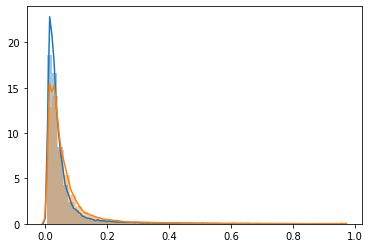

In [35]:
sns.distplot(np.sqrt(val_preds))
sns.distplot(np.sqrt(test_preds))

In [36]:
test = pd.read_csv('data/test.csv')
sub = test[['id']]
sub['redemption_status'] = test_preds
sub.head()

/home/mohsin/kg7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,redemption_status
0,3,0.354197
1,4,0.006553
2,5,0.010919
3,8,0.000963
4,10,0.000716


In [26]:
sub.to_csv('data/sub_model8.csv', index=False)